<a href="https://colab.research.google.com/github/tarabelo/PIAC-apuntes/blob/main/Pr%C3%A1ctica%202%3A%20algoritmo%20de%20Deutsch-Jozsa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RAQUEL ALFONSO RODRÍGUEZ**

In [ ]:
### PREÁMBULO ###
!pip install qiskit qiskit-aer pylatexenc

In [1]:
import numpy as np
from math import sqrt

# importing Qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
# import basic plot tools
from qiskit.visualization import plot_histogram

# Funciones auxiliares

# Función para simular y mostrar el vector de estado
def obten_estado(qcirc, etiqueta="|\psi\!\!> = ", bloch=False):
    # Usamos el simulador de vector de estado
    # https://qiskit.github.io/qiskit-aer/stubs/qiskit_aer.AerSimulator.html
    sim = AerSimulator(method='statevector')
    qc_obj = transpile(qcirc, sim)
    result = sim.run(qc_obj).result()
    estado = result.get_statevector()
    display(estado.draw('latex', prefix=etiqueta))
    if bloch:
      display(estado.draw('bloch'))

# Funcion para obtener y mostrar la matriz unitaria
def obten_unitaria(qcirc, etiqueta):
    # Usamos el simulador de matriz unitaria
    sim_u = AerSimulator(method='unitary')
    qc_obj = transpile(qcirc, sim_u)
    result = sim_u.run(qcirc).result()
    unitary = result.get_unitary(qcirc)
    display(unitary.draw('latex', prefix=etiqueta))

# Práctica 2: algoritmo de  Deutsch-Jozsa

Implementa en Qiskit el algoritmo de Deutsch-Jozsa para un $n$ arbitrario.

Pasos:

1. Crea una función que devuelva un oráculo para $f$ constante.

#### Solución ####

Como la función constante a 0 es muy sencilla y se traduce en el circuito identidad, vamos a aplicar un oráculo constante a 1, aplicando una negación al qubit $y$.

In [2]:
def cte_oraculo(n):
    """
    Define un oraculo para una función constante de n bits
        return: circuito de n+1 cúbits en forma de puerta
    """
    x = QuantumRegister(n, name="|x\\rangle")
    y = QuantumRegister(1, name="|y\\rangle")
    qc = QuantumCircuit(x,y)

    # TODO: Define el oráculo
    
    qc.x(y)

    # Salida
    return qc

2. Crea una función que devuelva un oráculo para $f$ balanceada.

#### Solución ####

Implementamos un circuito similar al de la primera práctica, solo que esta vez cumplirá

$$
f(x) =
\begin{cases}
0, \text{si } x \text{ es par}\\
1, \text{si } x \text{ es impar}\\
\end{cases}
$$

Al igual que en la práctica anterior, el bit que condiciona la paridad es el menos significativo, de manera que si $x_n = 0$ (eq. $x_n=1$), el número binario será par (eq. impar). Luego, basta implementar una puerta CNOT entre el qubit menos significativo y el qubit $y$.

In [3]:
def bal_oraculo(n):
    """
    Define un oraculo para una función balanceada de n bits
        return: circuito de n+1 cúbits en forma de puerta
    """
    x = QuantumRegister(n, name="|x\\rangle")
    y = QuantumRegister(1, name="|y\\rangle")
    qc = QuantumCircuit(x,y)

    # TODO: Define el oráculo
    # El más simple se puede implementar con CNOTS,
    # de forma que f(x) = 0 si x tiene paridad par (nº de bits 1 par) o 1 en otro caso.
    
    qc.cx(x[0],y)

    # Salida
    return qc

3. Crea una función que devuelva una puerta oráculo cte. o balanceado según un parámetro de entrada

In [4]:
def dj_oraculo(n, tipo):
    """
    Devuelve un oraculo para el algoritmo de Deutsch-Jozsa

        n: Número de cúbits de entrada
        tipo: tipo de oráculo, 0 cte., 1 balanceado
        return: circuito de n+1 cúbit en forma de puerta
    """
    x = QuantumRegister(n, name="|x\\rangle")
    y = QuantumRegister(1, name="|y\\rangle")
    qc = QuantumCircuit(x,y)

    if tipo==0:
        qc = cte_oraculo(n)
    elif tipo==1:
        qc = bal_oraculo(n)
    else:
        print('Error: tipo debe ser 0 para constante o 1 para balanceado')

    # Salida
    oraculo = qc.to_gate()
    oraculo.name = "$U_{f}$"
    return oraculo

4. Implementa paso a paso el circuito completo del algoritmo de Deutsch-Jozsa:

Paso 0: Obtén el estado inicial:
        
$$\vert \psi_0 \rangle = \vert 1\rangle\vert0\rangle^{\otimes n} $$

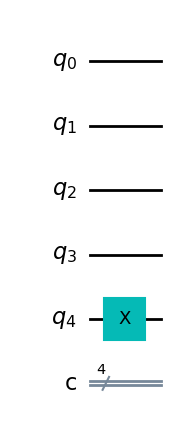

In [5]:
def paso_0(n):
    qc = QuantumCircuit(n+1,n)

    #
    # TODO: Añade las puertas necesarias para obtener el estado 𝜓0
    #
    qc.x(n)

    return qc

# Mostramos el circuito
n=4
paso_0(n).draw('mpl', style = 'clifford')

Paso 1: Obtén el estado
$$\vert \psi_1 \rangle = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1} \left(|0\rangle - |1 \rangle \right)\vert x\rangle $$

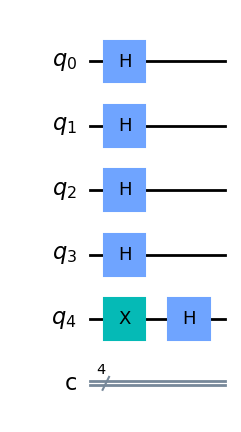

In [6]:
def paso_1(n):
    qc = paso_0(n)

    #
    # TODO: Añade las puertas necesarias para obtener el estado 𝜓1
    #
    for i in range(n+1):
        qc.h(i)

    return qc

# Mostramos el circuito
paso_1(n).draw('mpl', style = 'clifford')

Paso 2: Añadimos el oráculo para obtener:

$$
\lvert \psi_2 \rangle  
= \frac{|0\rangle - |1\rangle}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1}(-1)^{f(x)}|x\rangle  
$$

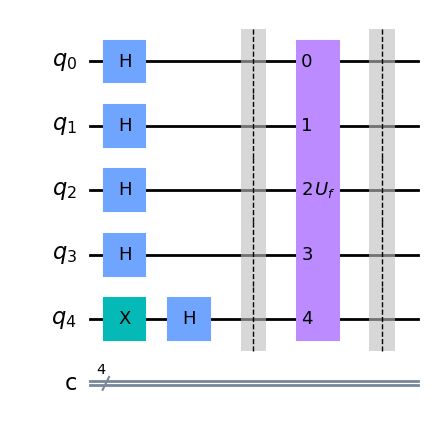

In [7]:
def paso_2(n, tipo_oraculo):
    qc = paso_1(n)

    # Añadimos barreras para una mejor visualización
    qc.barrier()

    # TODO: añade el oráculo
    qc = qc.compose(dj_oraculo(n,tipo_oraculo))
    
    qc.barrier()

    return qc

# Mostramos el circuito
paso_2(n, 1).draw('mpl', style = 'clifford')

Paso 3: Añade las últimas puertas H y la medida de los $n$ primeros cúbits.

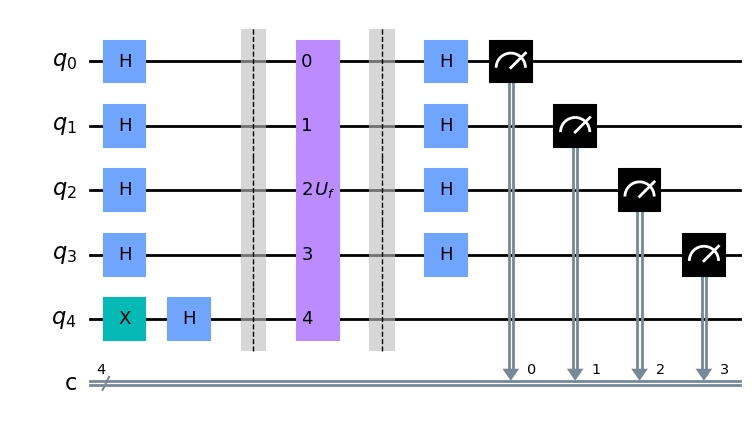

In [8]:
def paso_3(n, tipo_oraculo):
    qc = paso_2(n, tipo_oraculo)
    #
    # TODO: Añade las puertas H y la medida
    #
    for i in range(n):
        qc.h(i)
        qc.measure(i,i)

    return qc

# Selecciona un oráculo aleatorio
tipo_oraculo = np.random.randint(2)
dj_circuito = paso_3(n, tipo_oraculo)
dj_circuito.draw('mpl', style = 'clifford')

Simulamos el circuito y obtenemos un histograma de la salida:

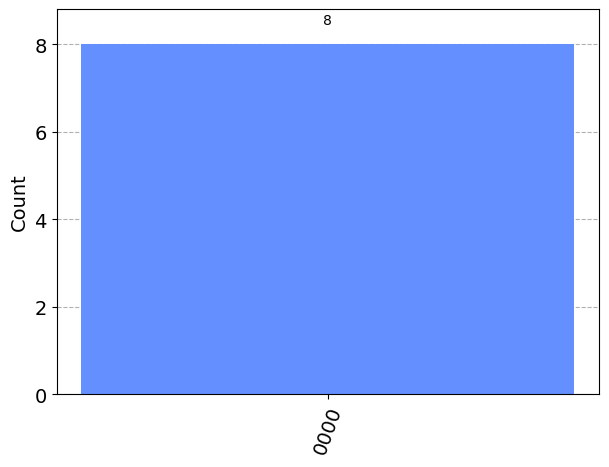

In [9]:
# Usamos un simulador local

sim = AerSimulator(method='automatic')
qc_obj = transpile(dj_circuito, sim)
result = sim.run(qc_obj, shots = 8).result()
salida = result.get_counts()
plot_histogram(salida)

Verifica que si el oráculo es constante, la salida es 0, y si es balanceado es $\ne 0$.

#### Solución ####

Verificamos que para $\verb|tipo_oraculo = 0|$, el resultado es siempre 0 y para $\verb|tipo_oraculo = 1|$, es distinto de cero. Las ejecuciones están recogidas en las siguientes dos celdas.

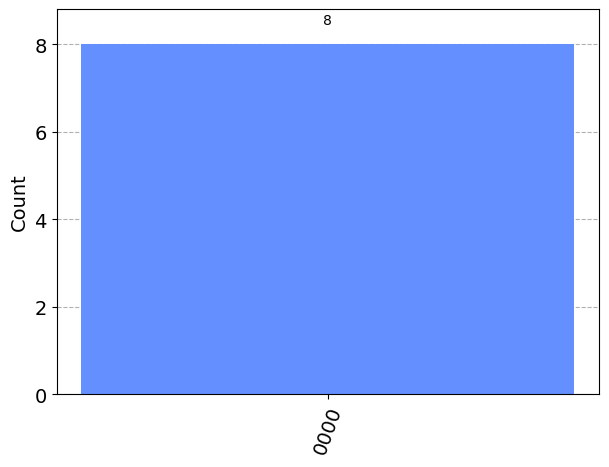

In [10]:
# FUNCIÓN CONSTANTE

dj_circuito = paso_3(4, tipo_oraculo=0)
sim = AerSimulator(method='automatic')
qc_obj = transpile(dj_circuito, sim)
result = sim.run(qc_obj, shots = 8).result()
salida = result.get_counts()
plot_histogram(salida)

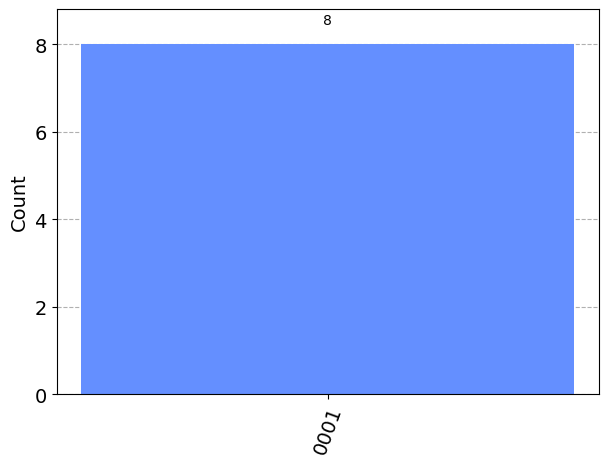

In [11]:
# FUNCION BALANCEADA

dj_circuito = paso_3(4, tipo_oraculo=1)
sim = AerSimulator(method='automatic')
qc_obj = transpile(dj_circuito, sim)
result = sim.run(qc_obj, shots = 8).result()
salida = result.get_counts()
plot_histogram(salida)

-----------------------------
-----------------------------
-----------------------------